# MRMS Precipitation Plots
By: Ty Janoski

## Setup

In [1]:
# import statements

import gzip
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from io import BytesIO
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from metpy.plots import ctables
import cartopy.feature as cfeature
import matplotlib.colors as mcolors


In [2]:
# Make the above code into a function
def read_in_mrms_data(bucket_name: str, path: str, hour: str) -> xr.DataArray:
    # Set up S3 client
    s3 = boto3.client(
        "s3", region_name="us-east-1", config=Config(signature_version=UNSIGNED)
    )

    # List objects from AWS Bucket
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path)

    # Find key containing hour.grib2.gz, which is the file we want
    for obj in response["Contents"]:
        if f"{hour}.grib2.gz" in obj["Key"]:
            key = obj["Key"]
            break

    # Read in the file
    grib_data = BytesIO()
    s3.download_fileobj(bucket_name, key, grib_data)
    grib_data.seek(0)

    with tempfile.NamedTemporaryFile(suffix=".grib2", delete=False) as tmp_file:
        with gzip.open(grib_data, "rb") as f:
            tmp_file.write(f.read())
        tmp_file_path = tmp_file.name

        
        da = xr.open_dataarray(tmp_file_path, engine="cfgrib")

    return da
    

In [3]:
# Read in 0100-0200 UTC hourly rainfall and the
# 24-hour accumulated rainfall for 1200-1200 UTC 1-2 September 2021

# Set bucket name
bucket_name = "noaa-mrms-pds"

# Read in rainfall
hourly = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_01H_Pass2_00.00/20210902/", "020000"
)
daily = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_24H_Pass2_00.00/20210902/", "120000"
)


In [4]:
# Read in any WoFS simulation to get some projection attrs
wofs = xr.open_dataset("/mnt/drive2/new-wofs/20Z/wofs_ALL_43_20210901_2000_2335.nc")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs.attrs["CEN_LON"],
    central_latitude=wofs.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)

# latitude and longitude
lat = hourly.latitude
lon = hourly.longitude

# Get MetPy ctable for precip
precip_cmap = ctables.registry.get_colortable("precipitation")


## Plots

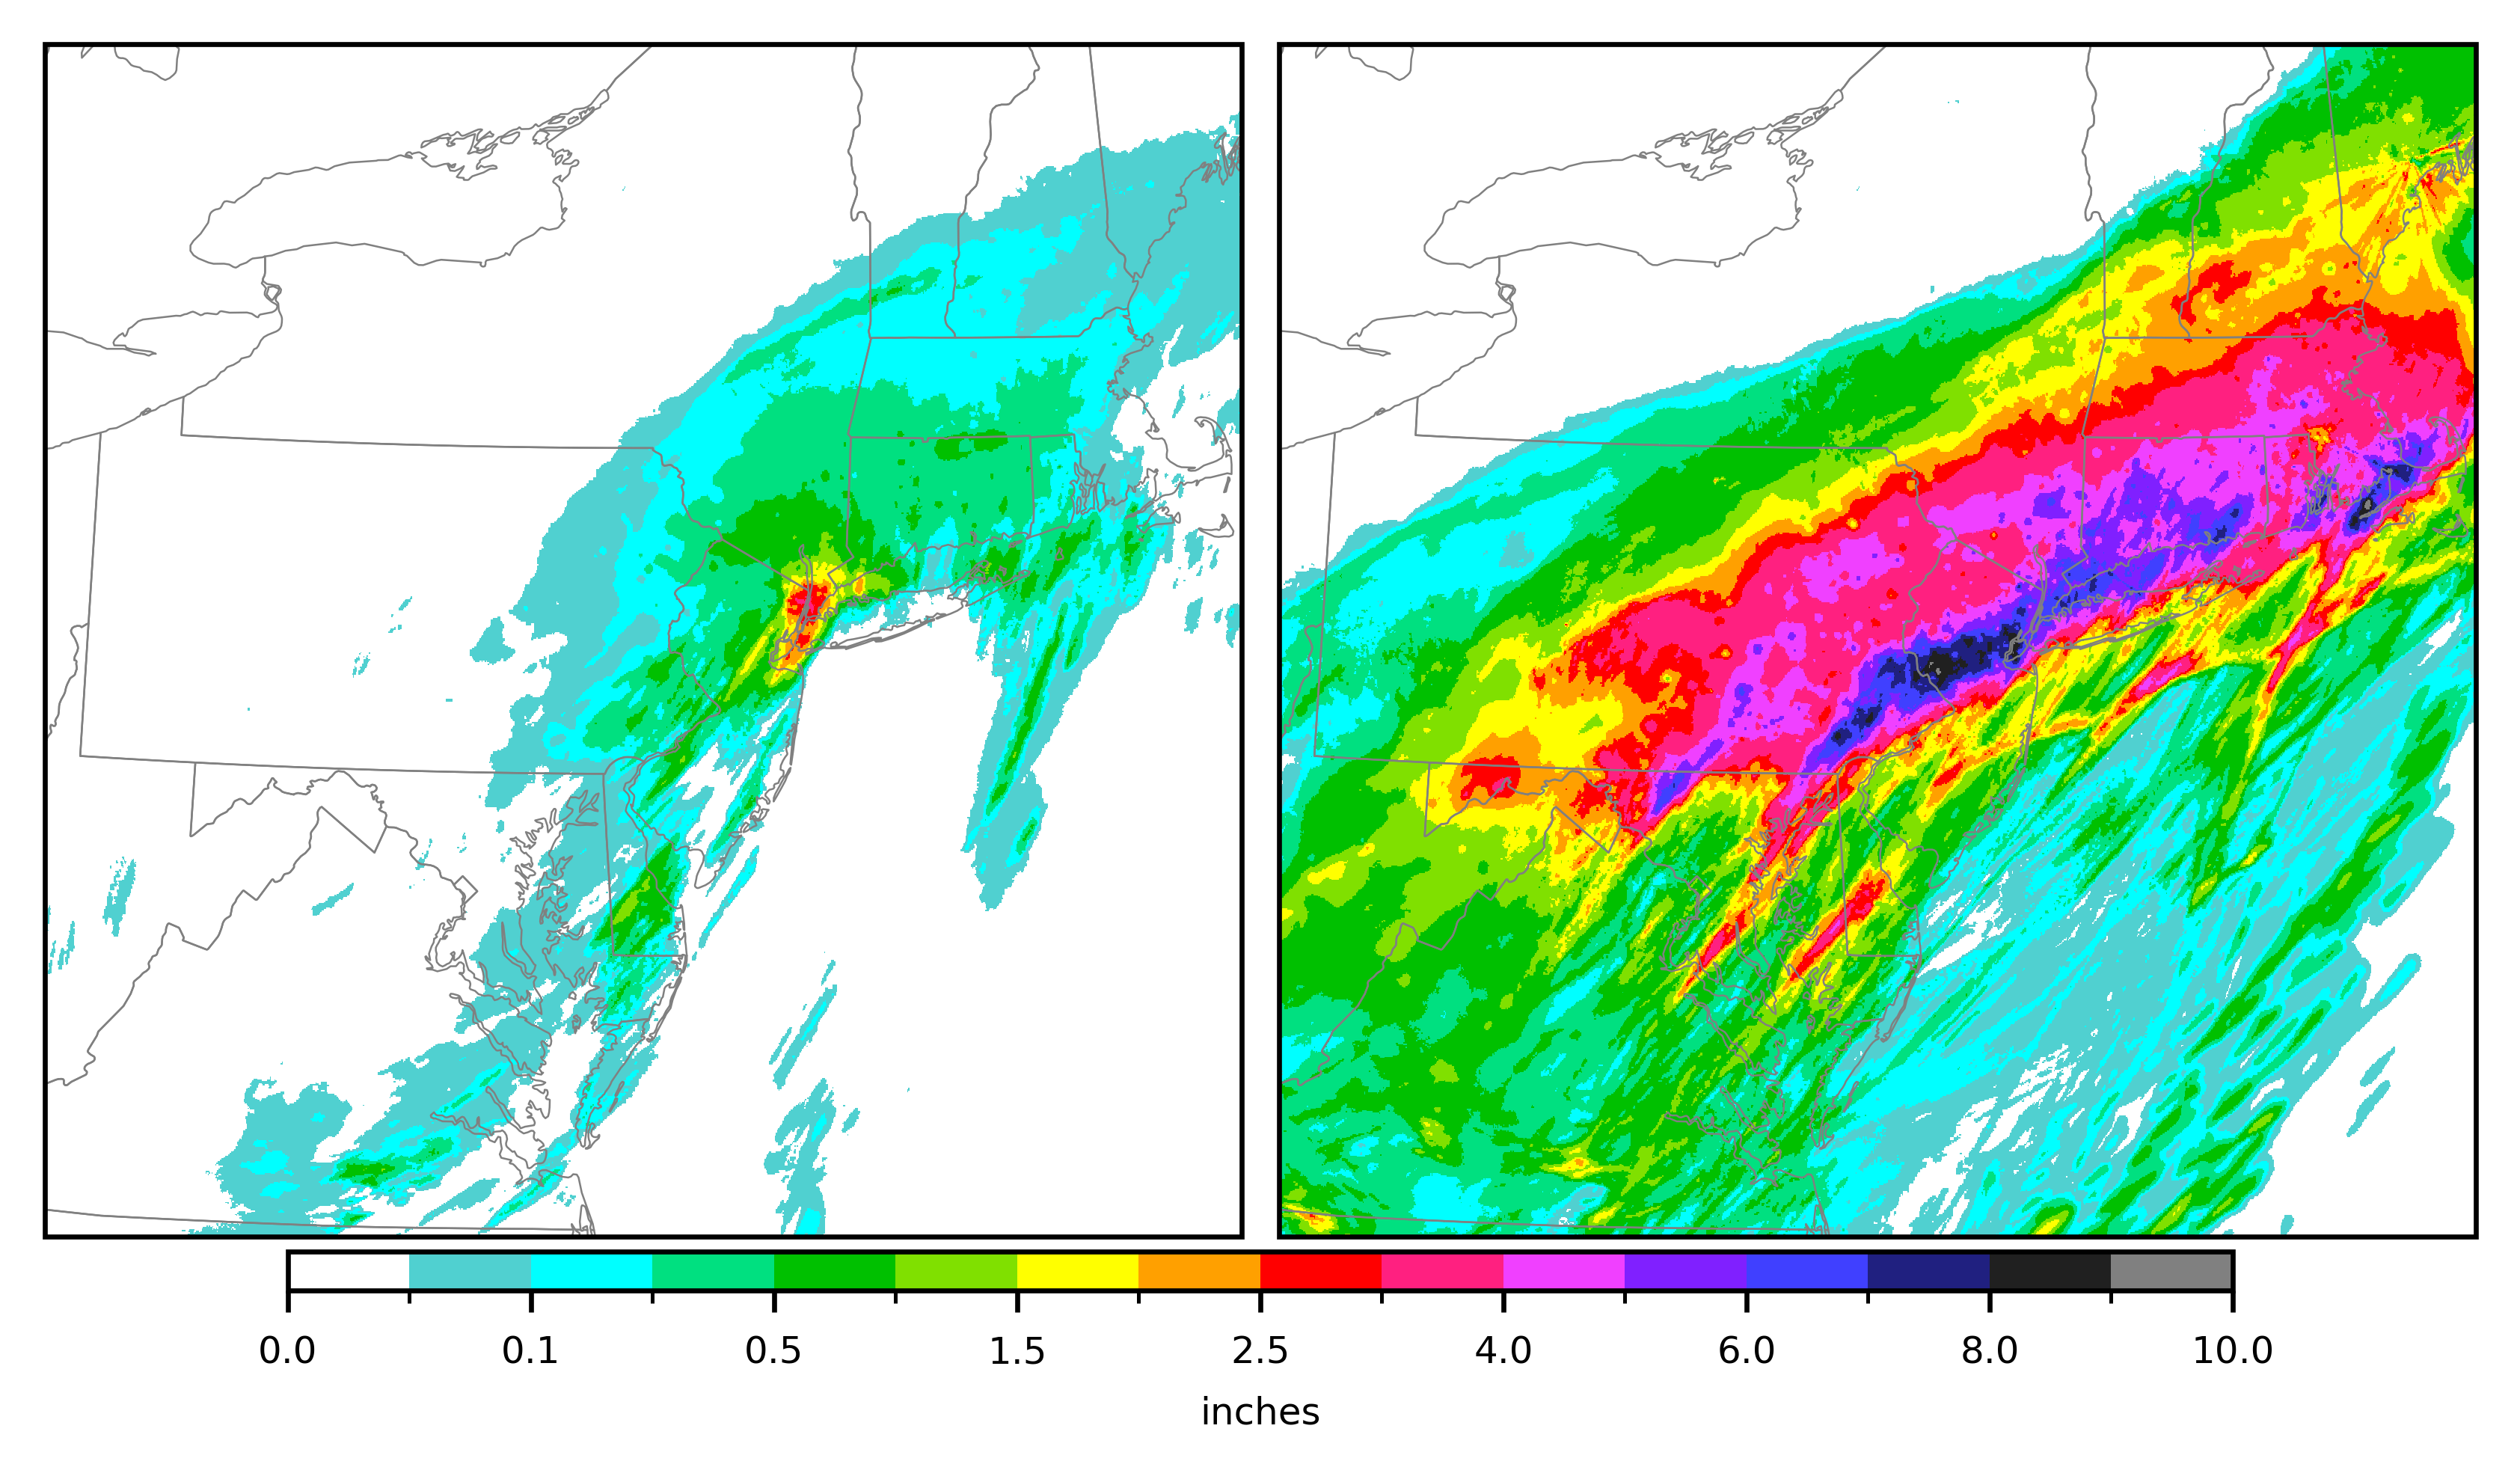

In [11]:
# Set levels
levels = [0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]

# Create a normalization object
norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

# Make a plot of the hourly rainfall
fig, axes = plt.subplots(
    1,
    2,
    figsize=(5.5, 3.2),
    dpi=600,
    subplot_kw={"projection": proj},
    layout="constrained",
)

# Plot the hourly rainfall
pc1 = axes[0].pcolormesh(
    lon,
    lat,
    hourly / 25.4,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cmap=precip_cmap,  # type: ignore
)

# Plot the 24-hour rainfall
pc2 = axes[1].pcolormesh(
    lon,
    lat,
    daily / 25.4,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cmap=precip_cmap,  # type: ignore
)

for ax in axes:
    ax.set_extent(  # type: ignore
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="gray")  # type: ignore

# Add colorbar to figure
cb = fig.colorbar(pc1, ax=axes, orientation="horizontal", pad=0.01, aspect=50, shrink=0.8)
cb.set_label("inches",fontsize=6)
cb.ax.tick_params(labelsize=6)

# Show figure
plt.show()
